In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

In [3]:
from typing import List

import random
import collections
import time

In [11]:
# мои гиперматетры
SEED = 42
ENV_NAME = 'MountainCar-v0'
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
BUFFER_SIZE = 100_000
MIN_REPLAY_SIZE = 1000
TARGET_UPDATE_STEPS = 1000 
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY_STEPS = 50_000  
MAX_EPISODES = 400
MAX_STEPS_PER_EPISODE = 200
HIDDEN_SIZES = [128, 128]
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer: Deque = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.uint8),
        )

    def __len__(self):
        return len(self.buffer)

In [35]:
# q-network
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_sizes: List[int]):
        super().__init__()
        layers = []
        last = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU())
            last = h
        layers.append(nn.Linear(last, output_dim))  
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [48]:
# вознаграждение не констант -1
# Я формировал вознаграждение на основе прогресса (дельта позиции)
# бонус даем за достижение цели
# стабильность обучения и более плотный обучающий сигнал, чем стандартное -1 за шаг
class ShapedRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.prev_position = None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_position = float(obs[0])
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        pos = float(obs[0])
        progress = pos - self.prev_position
        shaped = progress * 100.0  
        shaped += abs(obs[1]) * 10.0 
        shaped -= 0.1
        done = terminated or truncated
        if terminated:
            shaped += 100.0
        self.prev_position = pos
        return obs, shaped, terminated, truncated, info

In [71]:
# dqn agent
class DQNAgent:
    def __init__(self, obs_dim, n_actions):
        self.q_net = QNetwork(obs_dim, n_actions, HIDDEN_SIZES).to(DEVICE)
        self.target_net = QNetwork(obs_dim, n_actions, HIDDEN_SIZES).to(DEVICE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=LR)
        self.replay = ReplayBuffer(BUFFER_SIZE)
        self.n_actions = n_actions
        self.total_steps = 0

    def select_action(self, state, eps) -> int:
        if random.random() < eps:
            return random.randrange(self.n_actions)
        state_t = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.q_net(state_t)
            return int(q_vals.argmax(dim=1).item())

    def train_step(self):
        if len(self.replay) < MIN_REPLAY_SIZE:
            return None
        states, actions, rewards, next_states, dones = self.replay.sample(BATCH_SIZE)
        states_t = torch.tensor(states, dtype=torch.float32, device=DEVICE)
        actions_t = torch.tensor(actions, dtype=torch.int64, device=DEVICE).unsqueeze(1)
        rewards_t = torch.tensor(rewards, dtype=torch.float32, device=DEVICE).unsqueeze(1)
        next_states_t = torch.tensor(next_states, dtype=torch.float32, device=DEVICE)
        dones_t = torch.tensor(dones, dtype=torch.float32, device=DEVICE).unsqueeze(1)

        q_values = self.q_net(states_t).gather(1, actions_t)

        with torch.no_grad():
            next_q_values = self.target_net(next_states_t)
            max_next_q_values = next_q_values.max(dim=1, keepdim=True)[0]
            target_q = rewards_t + (1.0 - dones_t) * GAMMA * max_next_q_values

        loss = nn.functional.mse_loss(q_values, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 10.0)
        self.optimizer.step()

        return loss.item()

    def maybe_update_target(self):
        self.total_steps += 1
        if self.total_steps % TARGET_UPDATE_STEPS == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

In [81]:
def linear_eps(step, start=EPS_START, end=EPS_END, decay=EPS_DECAY_STEPS):
    if step >= decay:
        return end
    return start + (end - start) * (step / decay)

In [90]:
def moving_average(a, window=100):
    if len(a) < window:
        return np.mean(a)
    return np.mean(a[-window:])

EP   10 | GSteps   2000 | EpReward  -13.93 | MA100   -9.26 | EpSteps 200 | MeanEpSteps10 200.0 | Loss 0.0068 | EPS 0.960
EP   20 | GSteps   4000 | EpReward   -8.47 | MA100   -6.92 | EpSteps 200 | MeanEpSteps10 200.0 | Loss 0.0300 | EPS 0.921
EP   30 | GSteps   6000 | EpReward  -29.83 | MA100  -10.50 | EpSteps 200 | MeanEpSteps10 200.0 | Loss 0.0757 | EPS 0.881
EP   40 | GSteps   8000 | EpReward    1.47 | MA100  -11.41 | EpSteps 200 | MeanEpSteps10 200.0 | Loss 0.1717 | EPS 0.842
EP   50 | GSteps  10000 | EpReward   -5.90 | MA100  -11.98 | EpSteps 200 | MeanEpSteps10 200.0 | Loss 0.4934 | EPS 0.802
EP   60 | GSteps  12000 | EpReward    0.55 | MA100  -10.77 | EpSteps 200 | MeanEpSteps10 200.0 | Loss 0.4638 | EPS 0.762
EP   70 | GSteps  14000 | EpReward  -20.73 | MA100  -10.63 | EpSteps 200 | MeanEpSteps10 200.0 | Loss 0.8973 | EPS 0.723
EP   80 | GSteps  16000 | EpReward  -14.36 | MA100   -9.92 | EpSteps 200 | MeanEpSteps10 200.0 | Loss 1.1536 | EPS 0.683
EP   90 | GSteps  18000 | EpRewa

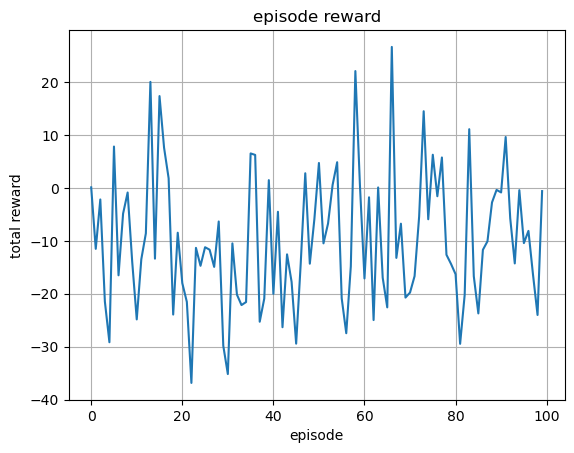

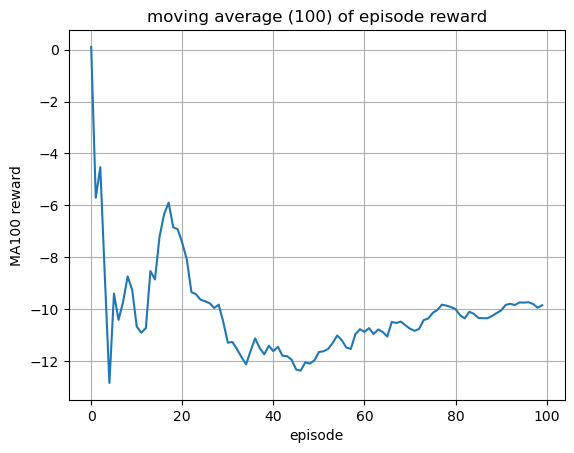

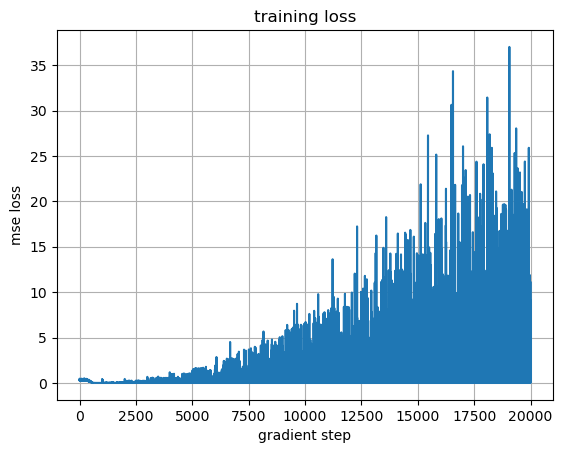

  episodes trained: 100
  final MA100 reward: -9.85
  final average episode length: 200.0


In [94]:
def main():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    env = gym.make(ENV_NAME)
    env = ShapedRewardWrapper(env)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    agent = DQNAgent(obs_dim, n_actions)

    episode_rewards = []
    episode_losses = []
    episode_steps = []
    all_losses = []

    global_step = 0

    obs, _ = env.reset()
    for _ in range(MIN_REPLAY_SIZE):
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.replay.push(obs, action, reward, next_obs, done)
        if done:
            obs, _ = env.reset()
        else:
            obs = next_obs

    start_time = time.time()

    for ep in range(1, MAX_EPISODES + 1):
        obs, _ = env.reset()
        total_reward = 0.0
        total_loss = 0.0
        losses_count = 0
        steps = 0
        done = False

        while not done and steps < MAX_STEPS_PER_EPISODE:
            eps = linear_eps(agent.total_steps)
            action = agent.select_action(obs, eps)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.replay.push(obs, action, reward, next_obs, done)

            loss = agent.train_step()
            if loss is not None:
                total_loss += loss
                losses_count += 1
                all_losses.append(loss)

            agent.maybe_update_target()

            obs = next_obs
            total_reward += reward
            steps += 1
            global_step += 1

        avg_loss = total_loss / losses_count if losses_count > 0 else 0.0
        episode_rewards.append(total_reward)
        episode_losses.append(avg_loss)
        episode_steps.append(steps)

        if ep % 10 == 0:
            ma_reward = moving_average(episode_rewards, 100)
            mean_steps = np.mean(episode_steps[-10:])
            print(f"EP {ep:4d} | GSteps {global_step:6d} | EpReward {total_reward:7.2f} | MA100 {ma_reward:7.2f} | EpSteps {steps:3d} | MeanEpSteps10 {mean_steps:.1f} | Loss {avg_loss:.4f} | EPS {eps:.3f}")

        if len(episode_rewards) >= 100 and moving_average(episode_rewards, 100) >= -110.0:
            print(f"environment in {ep} episodes. MA100 reward = {moving_average(episode_rewards,100):.2f}")
            break

    duration = time.time() - start_time
    print(f"training in {duration/60:.2f} min. episodes: {len(episode_rewards)}")

    torch.save(agent.q_net.state_dict(), 'dqn_mountaincar_shaped_reward.pth')

    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(episode_rewards)
    plt.title('episode reward')
    plt.xlabel('episode')
    plt.ylabel('total reward')
    plt.grid(True)
    plt.show()

    plt.figure()
    ma = [np.mean(episode_rewards[max(0, i-99):i+1]) for i in range(len(episode_rewards))]
    plt.plot(ma)
    plt.title('moving average (100) of episode reward')
    plt.xlabel('episode')
    plt.ylabel('MA100 reward')
    plt.grid(True)
    plt.show()

    # Loss plot
    plt.figure()
    plt.plot(all_losses)
    plt.title('training loss')
    plt.xlabel('gradient step')
    plt.ylabel('mse loss')
    plt.grid(True)
    plt.show()

    print(f'  episodes trained: {len(episode_rewards)}')
    print(f'  final MA100 reward: {moving_average(episode_rewards,100):.2f}')
    print(f'  final average episode length: {np.mean(episode_steps):.1f}')


if __name__ == '__main__':
    main()


для целей сравнения я сделал следующее:

In [95]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

In [99]:
from typing import List

import random
import collections
import time

In [104]:
SEED = 42
ENV_NAME = 'MountainCar-v0'
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
BUFFER_SIZE = 50_000
EPS_START, EPS_END = 1.0, 0.01
EPS_DECAY = 40_000
MAX_EPISODES = 300
MAX_STEPS = 200
HIDDEN = [128, 128]
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [111]:
# вознаграждение не констант -1
# Я формировал вознаграждение на основе прогресса (дельта позиции)
# бонус даем за достижение цели
# стабильность обучения и более плотный обучающий сигнал, чем стандартное -1 за шаг
class ShapedRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.prev_pos = None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_pos = obs[0]
        return obs, info

    def step(self, action):
        obs, r, term, trunc, info = self.env.step(action)
        pos, vel = obs
        delta = pos - self.prev_pos
        shaped = delta * 100 + abs(vel) * 10 - 0.1
        if term:
            shaped += 100
        self.prev_pos = pos
        return obs, shaped, term, trunc, info

In [123]:
# qnetwork
class QNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, HIDDEN[0]), nn.ReLU(),
            nn.Linear(HIDDEN[0], HIDDEN[1]), nn.ReLU(),
            nn.Linear(HIDDEN[1], out_dim)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
#1)unstable
class UnstableAgent:
    def __init__(self, obs_dim, n_actions):
        self.q = QNet(obs_dim, n_actions).to(DEVICE)
        self.opt = optim.Adam(self.q.parameters(), lr=LR)
        self.n_actions = n_actions

    def act(self, s, eps):
        if random.random() < eps:
            return random.randrange(self.n_actions)
        with torch.no_grad():
            s_t = torch.tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            return int(self.q(s_t).argmax(1).item())

    def train_step(self, s, a, r, s2, done):
        s_t = torch.tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        s2_t = torch.tensor(s2, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        a_t = torch.tensor([[a]], dtype=torch.int64, device=DEVICE)
        r_t = torch.tensor([[r]], dtype=torch.float32, device=DEVICE)
        d_t = torch.tensor([[done]], dtype=torch.float32, device=DEVICE)

        q_val = self.q(s_t).gather(1, a_t)
        with torch.no_grad():
            q_next = self.q(s2_t).max(1, keepdim=True)[0]
            target = r_t + (1 - d_t) * GAMMA * q_next
        loss = nn.functional.mse_loss(q_val, target)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()

In [146]:
# dqn(stabilized)
class Replay:
    def __init__(self, size):
        self.buf = collections.deque(maxlen=size)
    def push(self, *exp):
        self.buf.append(exp)
    def sample(self, n):
        batch = random.sample(self.buf, n)
        s,a,r,s2,d = zip(*batch)
        return (np.array(s), np.array(a), np.array(r), np.array(s2), np.array(d))
    def __len__(self):
        return len(self.buf)

class DQNAgent:
    def __init__(self, obs_dim, n_actions):
        self.q = QNet(obs_dim, n_actions).to(DEVICE)
        self.target = QNet(obs_dim, n_actions).to(DEVICE)
        self.target.load_state_dict(self.q.state_dict())
        self.opt = optim.Adam(self.q.parameters(), lr=LR)
        self.replay = Replay(BUFFER_SIZE)
        self.n_actions = n_actions
        self.steps = 0

    def act(self, s, eps):
        if random.random() < eps:
            return random.randrange(self.n_actions)
        with torch.no_grad():
            s_t = torch.tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            return int(self.q(s_t).argmax(1).item())

    def train_step(self):
        if len(self.replay) < BATCH_SIZE: return None
        s,a,r,s2,d = self.replay.sample(BATCH_SIZE)
        s_t = torch.tensor(s, dtype=torch.float32, device=DEVICE)
        s2_t = torch.tensor(s2, dtype=torch.float32, device=DEVICE)
        a_t = torch.tensor(a, dtype=torch.int64, device=DEVICE).unsqueeze(1)
        r_t = torch.tensor(r, dtype=torch.float32, device=DEVICE).unsqueeze(1)
        d_t = torch.tensor(d, dtype=torch.float32, device=DEVICE).unsqueeze(1)

        q_val = self.q(s_t).gather(1, a_t)
        with torch.no_grad():
            q_next = self.target(s2_t).max(1, keepdim=True)[0]
            target = r_t + (1 - d_t) * GAMMA * q_next
        loss = nn.functional.mse_loss(q_val, target)
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        if self.steps % 1000 == 0:
            self.target.load_state_dict(self.q.state_dict())
        self.steps += 1
        return loss.item()

In [161]:
# train. общий
def train(agent, env, use_replay=False):
    rewards, losses, steps_list = [], [], []
    eps = EPS_START
    for ep in range(MAX_EPISODES):
        s, _ = env.reset(); total_r = 0; total_l = 0; n_l = 0
        for t in range(MAX_STEPS):
            eps = max(EPS_END, EPS_START - (EPS_START-EPS_END)* (ep*MAX_STEPS+t)/EPS_DECAY)
            a = agent.act(s, eps)
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc
            if isinstance(agent, DQNAgent):
                agent.replay.push(s,a,r,s2,done)
                l = agent.train_step()
            else:
                l = agent.train_step(s,a,r,s2,done)
            if l: total_l += l; n_l += 1
            total_r += r
            s = s2
            if done: break
        rewards.append(total_r)
        losses.append(total_l/n_l if n_l>0 else 0)
        steps_list.append(t)
    return rewards, losses, steps_list

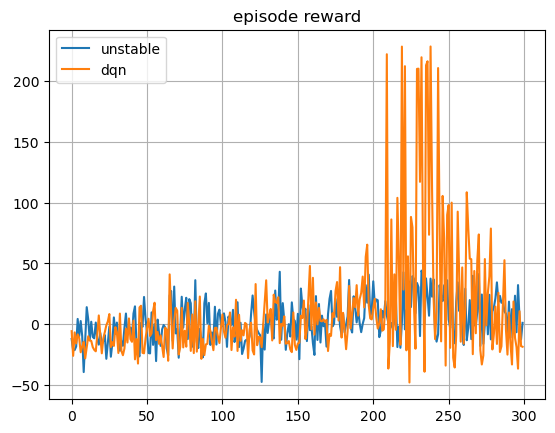

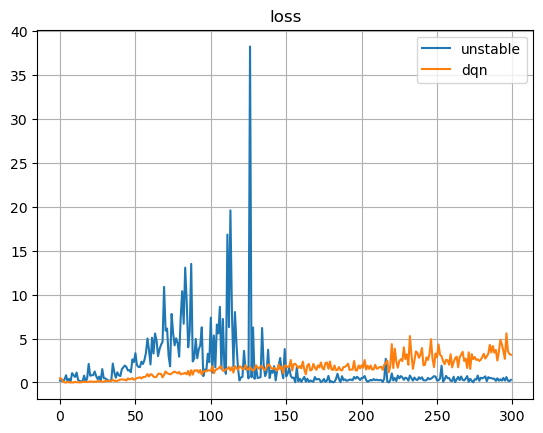

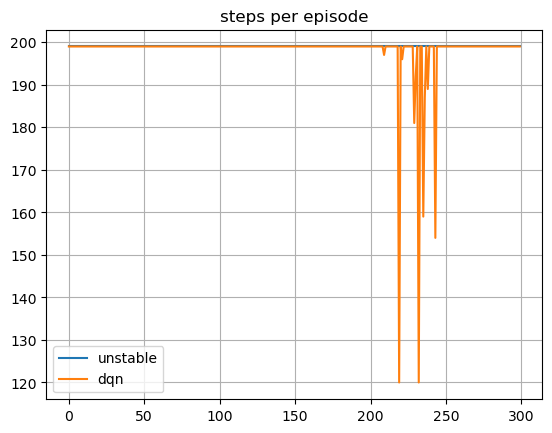

In [163]:
# сравнение
def main():
    random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

    env = gym.make(ENV_NAME)
    env = ShapedRewardWrapper(env)
    obs_dim = env.observation_space.shape[0]; n_actions = env.action_space.n

    unstab = UnstableAgent(obs_dim, n_actions)
    r1,l1,s1 = train(unstab, env)

    stab = DQNAgent(obs_dim, n_actions)
    s,_ = env.reset()
    for _ in range(1000):
        a = env.action_space.sample()
        s2,r,t,tr,_ = env.step(a)
        stab.replay.push(s,a,r,s2,t or tr)
        s = s2 if not (t or tr) else env.reset()[0]
    r2,l2,s2 = train(stab, env, True)
      
    import matplotlib.pyplot as plt        
    plt.figure(); plt.plot(r1, label='unstable'); plt.plot(r2, label='dqn'); plt.legend(); plt.title('episode reward'); plt.grid(True)
    plt.figure(); plt.plot(l1, label='unstable'); plt.plot(l2, label='dqn'); plt.legend(); plt.title('loss'); plt.grid(True)
    plt.figure(); plt.plot(s1, label='unstable'); plt.plot(s2, label='dqn'); plt.legend(); plt.title('steps per episode'); plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()